# Multi-Agent Researcher

This notebook demonstrates the multi-agent research approach, which uses a supervisor-researcher collaborative pattern to create comprehensive reports. The system consists of:

1. A **Supervisor Agent** that plans the overall report structure and coordinates work
2. Multiple **Research Agents** that investigate specific topics in parallel
3. A workflow that produces a structured report with introduction, body sections, and conclusion

## Setup

We'll switch to the src directory and load in our environment variables.

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/robertxu/Desktop/Projects/eng/open_deep_research/src


In [3]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

Let's import the helpers we'll need to build our agent.

In [4]:
from agents.multiagents.graph import (
    get_research_tools, 
    get_supervisor_tools, 
    get_search_tool, 
    _load_mcp_tools
)

from agents.multiagents.graph import (
    Section,
    Sections,
    Introduction,
    Conclusion,
    Question,
    FinishResearch,
    FinishReport,
)

from agents.multiagents.utils import (
    get_config_value,
    tavily_search,
    duckduckgo_search,
    get_today_str,
)

from agents.multiagents.prompts import SUPERVISOR_INSTRUCTIONS, RESEARCH_INSTRUCTIONS
from agents.multiagents.configuration import MultiAgentConfiguration

## Supervisor Agent

We'll start by defining the supervisor agent in our multiagent system.

### State

We'll track the building blocks of our report in our state. We'll assume our research will be broken down into sections, each with research sources.

In [7]:
from typing import Annotated, TypedDict
from langgraph.graph import MessagesState
import operator

class ReportStateOutput(MessagesState):
    final_report: str # Final report
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search

class ReportState(MessagesState):
    sections: list[str] # List of report sections 
    completed_sections: Annotated[list[Section], operator.add] # Send() API key
    final_report: str # Final report
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: Annotated[str, operator.add] # String of formatted source content from web search

class SectionState(MessagesState):
    section: str # Report section  
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API
    # for evaluation purposes only
    # this is included only if configurable.include_source_str is True
    source_str: str # String of formatted source content from web search

### Nodes

Next, we'll define our supervisor. This will follow the classic ReAct agent architecture, with a reasoning step and a tools step. However, the tools will serve to handoff control to a dedicated team of subagents.

First, the reasoning node:

In [8]:
from langchain_core.runnables import RunnableConfig
from langchain.chat_models import init_chat_model

async def supervisor(state: ReportState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""

    # Messages
    messages = state["messages"]

    # Get configuration
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    supervisor_model = get_config_value(configurable.supervisor_model)

    # Initialize the model
    llm = init_chat_model(model=supervisor_model)
    
    # If sections have been completed, but we don't yet have the final report, then we need to initiate writing the introduction and conclusion
    if state.get("completed_sections") and not state.get("final_report"):
        research_complete_message = {"role": "user", "content": "Research is complete. Now write the introduction and conclusion for the report. Here are the completed main body sections: \n\n" + "\n\n".join([s.content for s in state["completed_sections"]])}
        messages = messages + [research_complete_message]

    # Get tools based on configuration
    supervisor_tool_list = await get_supervisor_tools(config)
    
    
    llm_with_tools = (
        llm
        .bind_tools(
            supervisor_tool_list,
            parallel_tool_calls=False,
            # force at least one tool call
            tool_choice="any"
        )
    )

    # Get system prompt
    system_prompt = SUPERVISOR_INSTRUCTIONS.format(today=get_today_str())
    if configurable.mcp_prompt:
        system_prompt += f"\n\n{configurable.mcp_prompt}"

    # Invoke
    return {
        "messages": [
            await llm_with_tools.ainvoke(
                [
                    {
                        "role": "system",
                        "content": system_prompt
                    }
                ]
                + messages
            )
        ]
    }

Next, the tools node to implement handoffs and routing. Note that we use Command to directly handoff to subagents, and update their State. 

We also utilize the Send method, which allows us to utilize map reduce functionality within LangGraph. This will spin up an arbitrary number of subagents depending on the need.

In [9]:
from typing import Literal, cast
from langchain_core.runnables import RunnableConfig
from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph

async def supervisor_tools(state: ReportState, config: RunnableConfig)  -> Command[Literal["supervisor", "research_team", "__end__"]]:
    """Performs the tool call and sends to the research agent"""
    configurable = MultiAgentConfiguration.from_runnable_config(config)

    result = []
    sections_list = []
    intro_content = None
    conclusion_content = None
    source_str = ""

    # Get tools based on configuration
    supervisor_tool_list = await get_supervisor_tools(config)
    supervisor_tools_by_name = {tool.name: tool for tool in supervisor_tool_list}
    search_tool_names = {
        tool.name
        for tool in supervisor_tool_list
        if tool.metadata is not None and tool.metadata.get("type") == "search"
    }

    # First process all tool calls to ensure we respond to each one (required for OpenAI)
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = supervisor_tools_by_name[tool_call["name"]]
        # Perform the tool call - use ainvoke for async tools
        try:
            observation = await tool.ainvoke(tool_call["args"], config)
        except NotImplementedError:
            observation = tool.invoke(tool_call["args"], config)

        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        
        # Store special tool results for processing after all tools have been called
        if tool_call["name"] == "Question":
            # Question tool was called - return to supervisor to ask the question
            question_obj = cast(Question, observation)
            result.append({"role": "assistant", "content": question_obj.question})
            return Command(goto=END, update={"messages": result})
        elif tool_call["name"] == "FinishReport":
            result.append({"role": "user", "content": "Report is Finish"})
            return Command(goto=END, update={"messages": result})
        elif tool_call["name"] == "Sections":
            sections_list = cast(Sections, observation).sections
        elif tool_call["name"] == "Introduction":
            # Format introduction with proper H1 heading if not already formatted
            observation = cast(Introduction, observation)
            if not observation.content.startswith("# "):
                intro_content = f"# {observation.name}\n\n{observation.content}"
            else:
                intro_content = observation.content
        elif tool_call["name"] == "Conclusion":
            # Format conclusion with proper H2 heading if not already formatted
            observation = cast(Conclusion, observation)
            if not observation.content.startswith("## "):
                conclusion_content = f"## {observation.name}\n\n{observation.content}"
            else:
                conclusion_content = observation.content
        elif tool_call["name"] in search_tool_names and configurable.include_source_str:
            source_str += cast(str, observation)

    # After processing all tool calls, decide what to do next
    if sections_list:
        # Send the sections to the research agents
        return Command(goto=[Send("research_team", {"section": s}) for s in sections_list], update={"messages": result})
    elif intro_content:
        # Store introduction while waiting for conclusion
        # Append to messages to guide the LLM to write conclusion next
        result.append({"role": "user", "content": "Introduction written. Now write a conclusion section."})
        state_update = {
            "final_report": intro_content,
            "messages": result,
        }
    elif conclusion_content:
        # Get all sections and combine in proper order: Introduction, Body Sections, Conclusion
        intro = state.get("final_report", "")
        body_sections = "\n\n".join([s.content for s in state["completed_sections"]])
        
        # Assemble final report in correct order
        complete_report = f"{intro}\n\n{body_sections}\n\n{conclusion_content}"
        
        # Append to messages to indicate completion
        result.append({"role": "user", "content": "Report is now complete with introduction, body sections, and conclusion."})

        state_update = {
            "final_report": complete_report,
            "messages": result,
        }
    else:
        # Default case (for search tools, etc.)
        state_update = {"messages": result}

    # Include source string for evaluation
    if configurable.include_source_str and source_str:
        state_update["source_str"] = source_str

    return Command(goto="supervisor", update=state_update)


### Edges

The edges for our supervisor will follow the traditional ReAct agent architecture

In [6]:
async def supervisor_should_continue(state: ReportState) -> str:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # End because the supervisor asked a question or is finished
    if not last_message.tool_calls:
        # Exit the graph
        return END

    # If the LLM makes a tool call, then perform an action
    return "supervisor_tools"

## Research Team

Next, we'll define individual subagents that our supervisor agent can handoff to.

### Nodes

Like the supervisor, each subagent will use a modified ReAct architecture, with a reasoning step and a tools step.

Reasoning step:

In [10]:
async def research_agent(state: SectionState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""
    
    # Get configuration
    configurable = MultiAgentConfiguration.from_runnable_config(config)
    researcher_model = get_config_value(configurable.researcher_model)
    
    # Initialize the model
    llm = init_chat_model(model=researcher_model)

    # Get tools based on configuration
    research_tool_list = await get_research_tools(config)
    system_prompt = RESEARCH_INSTRUCTIONS.format(
        section_description=state["section"],
        number_of_queries=configurable.number_of_queries,
        today=get_today_str(),
    )
    if configurable.mcp_prompt:
        system_prompt += f"\n\n{configurable.mcp_prompt}"

    # Ensure we have at least one user message (required by Anthropic)
    messages = state.get("messages", [])
    if not messages:
        messages = [{"role": "user", "content": f"Please research and write the section: {state['section']}"}]

    return {
        "messages": [
            # Enforce tool calling to either perform more search or call the Section tool to write the section
            await llm.bind_tools(research_tool_list,             
                                 parallel_tool_calls=False,
                                 # force at least one tool call
                                 tool_choice="any").ainvoke(
                [
                    {
                        "role": "system",
                        "content": system_prompt
                    }
                ]
                + messages
            )
        ]
    }

Tools step:

In [11]:

async def research_agent_tools(state: SectionState, config: RunnableConfig):
    """Performs the tool call and route to supervisor or continue the research loop"""
    configurable = MultiAgentConfiguration.from_runnable_config(config)

    result = []
    completed_section = None
    source_str = ""
    
    # Get tools based on configuration
    research_tool_list = await get_research_tools(config)
    research_tools_by_name = {tool.name: tool for tool in research_tool_list}
    search_tool_names = {
        tool.name
        for tool in research_tool_list
        if tool.metadata is not None and tool.metadata.get("type") == "search"
    }
    
    # Process all tool calls first (required for OpenAI)
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = research_tools_by_name[tool_call["name"]]
        # Perform the tool call - use ainvoke for async tools
        try:
            observation = await tool.ainvoke(tool_call["args"], config)
        except NotImplementedError:
            observation = tool.invoke(tool_call["args"], config)

        # Append to messages 
        result.append({"role": "tool", 
                       "content": observation, 
                       "name": tool_call["name"], 
                       "tool_call_id": tool_call["id"]})
        
        # Store the section observation if a Section tool was called
        if tool_call["name"] == "Section":
            completed_section = cast(Section, observation)

        # Store the source string if a search tool was called
        if tool_call["name"] in search_tool_names and configurable.include_source_str:
            source_str += cast(str, observation)
    
    # After processing all tools, decide what to do next
    state_update = {"messages": result}
    if completed_section:
        # Write the completed section to state and return to the supervisor
        state_update["completed_sections"] = [completed_section]
    if configurable.include_source_str and source_str:
        state_update["source_str"] = source_str

    return state_update

### Edges

In [12]:
async def research_agent_should_continue(state: SectionState) -> str:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls[0]["name"] == "FinishResearch":
        # Research is done - return to supervisor
        return END
    else:
        return "research_agent_tools"

## Final Graph

In [19]:
from langgraph.checkpoint.memory import MemorySaver

# Research agent workflow
research_builder = StateGraph(SectionState, output=SectionOutputState, config_schema=MultiAgentConfiguration)
research_builder.add_node("research_agent", research_agent)
research_builder.add_node("research_agent_tools", research_agent_tools)
research_builder.add_edge(START, "research_agent") 
research_builder.add_conditional_edges(
    "research_agent",
    research_agent_should_continue,
    ["research_agent_tools", END]
)
research_builder.add_edge("research_agent_tools", "research_agent")

# Supervisor workflow
supervisor_builder = StateGraph(ReportState, input=MessagesState, output=ReportStateOutput, config_schema=MultiAgentConfiguration)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_node("research_team", research_builder.compile())

# Flow of the supervisor agent
supervisor_builder.add_edge(START, "supervisor")
supervisor_builder.add_conditional_edges(
    "supervisor",
    supervisor_should_continue,
    ["supervisor_tools", END]
)
supervisor_builder.add_edge("research_team", "supervisor")


# Compile the graph
checkpointer = MemorySaver()
graph = supervisor_builder.compile(checkpointer=checkpointer)


/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_66983/3715570504.py:4: LangGraphDeprecatedSinceV10: `config_schema` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_builder = StateGraph(SectionState, output=SectionOutputState, config_schema=MultiAgentConfiguration)
/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_66983/3715570504.py:4: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  research_builder = StateGraph(SectionState, output=SectionOutputState, config_schema=MultiAgentConfiguration)
/var/folders/jj/2fvdkyfj0856p6_6sdvv74rw0000gn/T/ipykernel_66983/3715570504.py:16: LangGraphDeprecatedSinceV10: `config_schema` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  supervisor_builder = StateGr

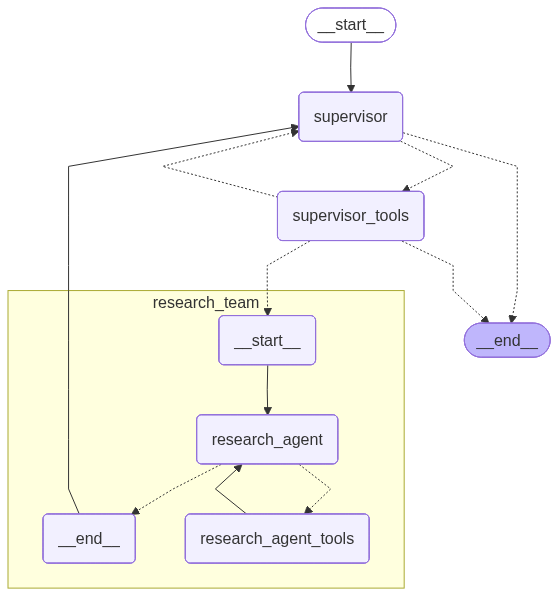

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png(max_retries=5)))

### Running our Agent

We can run our agent using the code below. NOTE that it does take several minutes to run, and consumes a large amount of tokens. 

As such, we've also included a sample trace of a successful run.

**Public Trace**: https://smith.langchain.com/public/407cd7fd-f3bc-45a8-9bea-38d9d84985e4/r

In [21]:
import uuid
# Configure and run the multi-agent system
# This sets up the model configuration and executes the research workflow

# Configure models and search API for both supervisor and researcher roles
config = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "tavily",
    "supervisor_model": "openai:gpt-4o-mini",
    "researcher_model": "openai:gpt-4o-mini",
}

# Set up thread configuration with the specified parameters
thread_config = {"configurable": config}

# Define the research topic as a user message
msg = [{"role": "user", "content": "What is model context protocol?"}]

# Run the multi-agent workflow with the specified configuration
response = await graph.ainvoke({"messages": msg}, config=thread_config)

Let's check out the result!

In [24]:
messages = graph.get_state(thread_config).values['messages']
for m in messages:
    m.pretty_print()

================================ Human Message =================================

What is model context protocol?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_d3clJQ3BDzxwDjoWy2QtnWNQ)
 Call ID: call_d3clJQ3BDzxwDjoWy2QtnWNQ
  Args:
    queries: ['model context protocol']
================================= Tool Message =================================
Name: tavily_search

Search results: 



--- SOURCE 1: Model Context Protocol ---
URL: https://modelcontextprotocol.io/

SUMMARY:
[Model Context Protocol home page![Image 1: light logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/light.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=4498cb8a57d574005f3dca62bdd49c95)![Image 2: dark logo](https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/dark.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=c0687c003f8f2cbdb24772ab4c8a522c)](https://modelcontextprotocol.io/) [Documentation](https://modelcontextprotocol.io/docs/getting-st